<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/autoencoder_with_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import math
from keras.models import Sequential, Model
from keras.layers import Input, Activation, CuDNNGRU, GRU, Dense,CuDNNLSTM, LSTM, RepeatVector
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, normalize
import holidays
from collections import OrderedDict, defaultdict
from google.colab import drive
import time
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [18, 5]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:

train = np.load('drive/My Drive/train_set.npy')
train.shape

(27222, 100, 9)

## AutoEncoder + GRU prediction

In [0]:
# !pip install fbprophet
# !pip install sklearn

In [0]:
req_sum = np.zeros(train.shape[1])
pred_req_sum = np.zeros(train.shape[1])
decoded_data = np.zeros(train.shape)
preds = np.zeros((train.shape[0], train.shape[1]))

num_features = train.shape[2]
encoding_dim = 4
window = 1

In [34]:


model = Sequential()
model.add(CuDNNGRU(64, input_shape=(window, encoding_dim)))
model.add(Dense(1))
model.add(Activation('relu'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_3 (CuDNNGRU)       (None, 64)                13440     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 13,505
Trainable params: 13,505
Non-trainable params: 0
_________________________________________________________________


### Train Simple Autoencoder

  - 100 days
  - 27222 features
  - 50 epochs

In [0]:
def get_simple_autoencoder(num_features,encoding_dim,window):
  compression_factor = float(num_features) / encoding_dim
  print("Compression factor: %s" % compression_factor)

  autoencoder = Sequential()
  autoencoder.add(Dense(encoding_dim, input_shape=(window,num_features,), activation='relu'))
  autoencoder.add(Dense(num_features, activation='relu'))
#   autoencoder.summary()

  input_encoder = Input(shape=(num_features,))
  encoder_layer = autoencoder.layers[0]
  encoder = Model(input_encoder, encoder_layer(input_encoder))

  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder

Compression factor: 9.0
27222/27222 [==============================] - 1s 37us/step
2558204.2296827924
encoding dimension 1
Compression factor: 3.0
27222/27222 [==============================] - 1s 38us/step
2558185.801714832
encoding dimension 3
Compression factor: 1.5
27222/27222 [==============================] - 1s 39us/step
784.5263901995611
encoding dimension 6
Compression factor: 1.2857142857142858
27222/27222 [==============================] - 1s 39us/step
581.8683535882968
encoding dimension 7


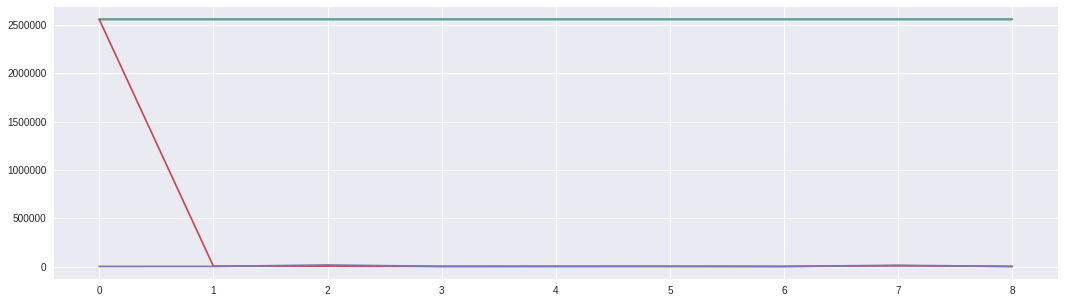

In [37]:
encoding_dims = [1,3,6,7]
num_days = 10
for encoding_dim in encoding_dims:
  autoencoder, encoder = get_simple_autoencoder(num_features,encoding_dim,window)
  ae_error = []
  for i in range(window, num_days if num_days<train.shape[1] else train.shape[1]):
    x = np.copy(train[:, i - window : i, :]).reshape(-1, window, train.shape[2])
#     print(x.shape)
  #   p = autoencoder.predict(x)
    start = time.clock()
    autoencoder.fit(x, x, epochs=50, verbose=0)
#     print(time.clock() - start)
#     print(str(i)+'/'+str(train.shape[1]))
    error = autoencoder.evaluate(x,x,verbose=0)
    ae_error.append(error)
  print(autoencoder.evaluate(x,x))
  print("encoding dimension", encoding_dim)
  autoencoder.save('drive/My Drive/autoencoder-'+str(encoding_dim))
  encoder.save('drive/My Drive/encoder-'+str(encoding_dim))
  plt.plot(ae_error)


### Train LSTM autoencoder
  
  - 100 days
  - 27222 features
  - 50 epochs

In [0]:
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

def get_lstm_autoencoder(num_features,encoding_dim,window):
  compression_factor = float(num_features) / encoding_dim
  print("Compression factor: %s" % compression_factor)
  inputs = Input(shape=(window, num_features))
  encoded = LSTM(encoding_dim)(inputs)

  decoded = RepeatVector(window)(encoded)
  decoded = LSTM(num_features, return_sequences=True)(decoded)

  sequence_autoencoder = Model(inputs, decoded)
  sequence_autoencoder.compile(optimizer='adam', loss='mse')
  encoder = Model(inputs, encoded)
  encoder.compile(optimizer='adam', loss='mse')
  return sequence_autoencoder, encoder

In [0]:
encoding_dims = [1,3,6,7]
num_days = 10
for encoding_dim in encoding_dims:
  autoencoder, encoder = get_lstm_autoencoder(num_features,encoding_dim,window)
  ae_error = []
  for i in range(window, num_days if num_days<train.shape[1] else train.shape[1]):
    x = np.copy(train[:, i - window : i, :]).reshape(-1, window, train.shape[2])
    print(x.shape)
  #   p = autoencoder.predict(x)
    start = time.clock()
    autoencoder.fit(x, x, epochs=50, verbose=0)
    print(time.clock() - start)
    print(str(i)+'/'+str(train.shape[1]))
    error = autoencoder.evaluate(x,x,verbose=0)
    ae_error.append(error)
  print(autoencoder.evaluate(x,x))
  autoencoder.save('drive/My Drive/lstm-autoencoder-'+str(encoding_dim))
  encoder.save('drive/My Drive/lstm-encoder-'+str(encoding_dim))
  plt.plot(ae_error)